In [ ]:
# # setup for the colab

# import os
# os.environ['KAGGLE_USERNAME'] = "kirillfedyanin"
# os.environ['KAGGLE_KEY'] = ""
# !pip install imageio
# !pip install keras 
# !pip install kaggle

# !kaggle competitions download -c tgs-salt-identification-challenge
# !mkdir -p test
# !mkdir -p train
# !unzip test.zip -d test
# !unzip train.zip -d train

In [20]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.layers import (Input, Dense, Dropout, Conv2D, UpSampling2D, MaxPooling2D, concatenate,
                          ZeroPadding2D, Cropping2D)
from keras.models import Model


In [54]:
HEIGHT, WIDTH = 101, 101
HEIGHT_TARGET, WIDTH_TARGET = 128, 128
MODEL_FILE = 'unet_basic.h5'
SUBMISSION_FILE = 'submission.csv'

In [34]:
root_path = './'

def get_image(file_id, mode='train'):
    image_path = os.path.join(root_path, mode, "images", file_id + '.png')
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    return image[:, :, 0]

def get_mask(file_id):
    mask_path = os.path.join(root_path, "train", "masks", file_id + '.png')
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
    return mask

In [21]:
train_values = pd.read_csv('train.csv')
file_list = list(train_values['id'])

# Reasearch
Do some data digging

In [ ]:
def rle_to_mask(rle_string):
    if isinstance(rle_string, float) and np.isnan(rle_string):
        return np.zeros((HEIGHT, WIDTH)) 
    rle_numbers = [int(num) for num in rle_string.split()] 
    rle_pairs = np.array(rle_numbers).reshape((-1, 2))
    
    mask = np.zeros(HEIGHT*WIDTH)
    for start, length in rle_pairs:
        mask[start-1: start-1+length] = 255
    
    mask = mask.reshape((HEIGHT, WIDTH)).T
        
    return mask


In [ ]:
# check if masks correctly oriented
for _ in range(15):
    i = random.randint(0, len(file_list)-1) 
    file_id = file_list[i]
    image, mask = get_image(file_id), get_mask(file_id)
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(rle_to_mask(train_values['rle_mask'][i]), cmap='gray')
    print(i, 'is correct: ', (mask==rle_to_mask(train_values['rle_mask'][i])).all())
    

(array([132., 162., 249., 281., 252., 275., 256., 296., 297., 346., 354.,
        392., 415., 458., 508., 489., 552., 536., 592., 592., 590., 615.,
        687., 646., 685., 654., 689., 722., 631., 649., 643., 623., 587.,
        581., 595., 559., 541., 526., 527., 458., 451., 471., 405., 427.,
        125., 105.,  88.,  80.,  87., 119.]),
 array([ 50.  ,  68.18,  86.36, 104.54, 122.72, 140.9 , 159.08, 177.26,
        195.44, 213.62, 231.8 , 249.98, 268.16, 286.34, 304.52, 322.7 ,
        340.88, 359.06, 377.24, 395.42, 413.6 , 431.78, 449.96, 468.14,
        486.32, 504.5 , 522.68, 540.86, 559.04, 577.22, 595.4 , 613.58,
        631.76, 649.94, 668.12, 686.3 , 704.48, 722.66, 740.84, 759.02,
        777.2 , 795.38, 813.56, 831.74, 849.92, 868.1 , 886.28, 904.46,
        922.64, 940.82, 959.  ]),
 <a list of 50 Patch objects>)

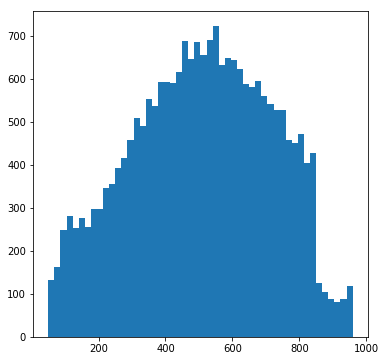

In [23]:
depths = pd.read_csv("depths.csv")

plt.figure(figsize=(6, 6))
plt.hist(depths['z'], bins=50)


In [24]:
norm = HEIGHT * WIDTH * 255.0
def salt_concentration(mask):
    return np.sum(mask)/norm

train_values['salt_concentration'] = [salt_concentration(get_mask(file_id)) for file_id in train_values['id']]

In [25]:
train_val = train_values.merge(depths, how='left')

Text(0.5, 1.0, 'Depths vs salt concentration')

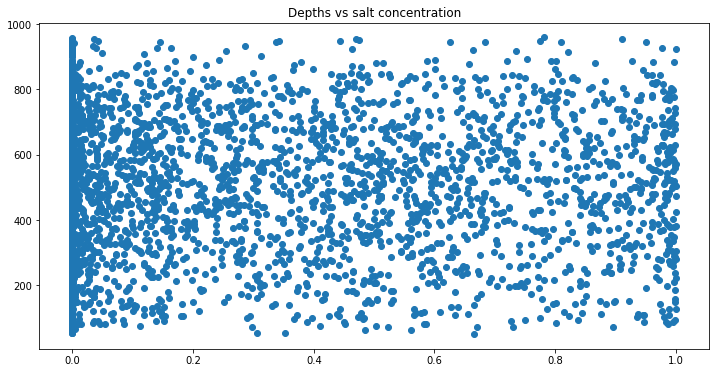

In [26]:
plt.figure(figsize=(12, 6))
plt.scatter(train_val['salt_concentration'], train_val['depths'])
plt.title("Depths vs salt concentration")

# Model training itself

**what to do**
- early stopping
- better resizing
- train_split, stratification
- augmentation
- deeper?
- refactor
- smart threshold


In [39]:
train_df = pd.read_csv('train.csv')
train_df['image'] = [get_image(file_id)/255.0 for file_id in train_df['id']]
train_df['mask'] = [get_mask(file_id)/255.0 for file_id in train_df['id']]



array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

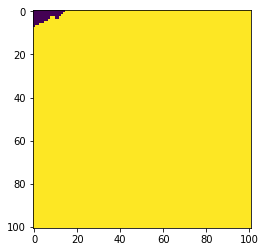

In [ ]:

def salt_detector():
    common_atr = {'activation': 'relu', 'padding': 'same'}
    
    input_image = Input(shape=(101, 101, 1))
#     x = ZeroPadding2D(((0, 27), (0, 27)))(input_image)
    conv1 = Conv2D(16, (3, 3), **common_atr)(input_image)
    conv1 = Conv2D(16, (3, 3), **common_atr)(conv1)
    max1 = MaxPooling2D((2, 2), padding='same')(conv1)
    max1 = Dropout(0.25)(max1)
    
    
    conv2 = Conv2D(32, (3, 3), **common_atr)(max1)
    conv2 = Conv2D(32, (3, 3), **common_atr)(conv2)
    max2 = MaxPooling2D((2, 2), padding='same')(conv2)
    max2 = Dropout(0.25)(max2)
    
    conv3 = Conv2D(64, (3, 3), **common_atr)(max2)
    conv3 = Conv2D(64, (3, 3), **common_atr)(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)
    encoded = Dropout(0.25)(encoded)
    
    conv10 = Conv2D(64, (3, 3), **common_atr)(encoded)
    conv10 = Conv2D(64, (3, 3), **common_atr)(conv10)
    
    up11 = UpSampling2D((2, 2))(conv10)
    merged11 = concatenate([up11, conv3], axis=3)
    merged11 = Dropout(0.25)(merged11)
    conv11 = Conv2D(32, (3, 3), **common_atr)(merged11)
    conv11 = Conv2D(32, (3, 3), **common_atr)(conv11)
    
    up12 = UpSampling2D((2, 2))(conv11)
    merged12 = concatenate([up12, conv2], axis=3)
    merged12 = Dropout(0.25)(merged12)
    conv12 = Conv2D(16, (3, 3), **common_atr)(merged12)
    conv12 = Conv2D(16, (3, 3), **common_atr)(conv12)
    
    up13 = UpSampling2D((2, 2))(conv12)
    merged13 = concatenate([up13, conv1], axis=3)
    merged13 = Dropout(0.25)(merged13)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(merged13)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(conv13)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv13)
#     decoded_cropped = Cropping2D(((0, 27), (0, 27)))(decoded)
    
    autoencoder = Model(input_image, decoded_cropped)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder

detector = salt_detector()
detector.summary()


In [64]:
def upsample(img):
    return resize(img, (HEIGHT_TARGET, WIDTH_TARGET), mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, (HEIGHT_TARGET, WIDTH_TARGET), mode='constant', preserve_range=True)

def prepare(images):
    return np.array(images.map(upsample).tolist()).reshape(-1, HEIGHT_TARGET, WIDTH_TARGET, 1)

In [65]:
val_size = 256 
images_train, images_val = prepare(train_df['image'][:-val_size]), prepare(train_df['image'][-val_size:])
masks_train, masks_val = prepare(train_df['mask'][:-val_size]), prepare(train_df['mask'][-val_size:])

In [66]:
detector.fit(images_train, masks_train, epochs=1, batch_size=32, shuffle=True, validation_data=(images_val, masks_val) )

ValueError: Error when checking input: expected input_3 to have shape (101, 101, 1) but got array with shape (128, 128, 1)

In [ ]:
!mkdir -p models
detector.save(os.path.join(root_path, 'models', MODEL_FILE))

In [ ]:
def threshold_image(image, threshold=0.65):
    image[image>threshold] = 1
    image[image<=threshold] = 0
    return image

In [ ]:
for i in range(10):
    image = images[i]
    label = labels[i]
    prediction = detector.predict(images[i:i+1])[0]
    _, axarr = plt.subplots(1, 4)
    axarr[0].imshow(image[:, :, 0], cmap='gray')
    axarr[1].imshow(label[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[2].imshow(prediction[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[3].imshow(threshold_image(prediction[:, :, 0], 0.2), cmap='gray', vmin=0, vmax=1)


In [ ]:
def encode_rle(mask):
    mask = mask.reshape(HEIGHT, WIDTH).T.reshape(-1)
    
    rle_array = []
    white_start = 0 
    for i, value in enumerate(mask):
        if value == 0 and white_start:
            rle_array.extend([white_start, i+1-white_start])
            white_start = 0
        elif value == 1 and not white_start:
            white_start = i + 1
    if white_start:
        rle_array.extend([white_start, len(mask)+1-white_start])
                
    rle_encoded = ' '.join(map(str, rle_array))
    return rle_encoded

In [ ]:
# validate rle encoder
for some_index in range(99):
    file_id_ = file_list[some_index]
    msk = get_mask(file_id_) / 255.0
    correct_mask = train_values['rle_mask'][some_index]
    encoded = encode_rle(msk)
    print(encoded == correct_mask or (not encoded and np.isnan(correct_mask)), end= ' ')

In [ ]:
test_path = os.path.join(root_path, 'test', 'images')
test_file_list = [os.path.splitext(file_name)[0] for file_name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, file_name))]

In [ ]:
test_images = prepare([get_image(file_id, 'test') for file_id in test_file_list])

In [ ]:
predicted = detector.predict(test_images[:5])
for i in range(5):
    f, axarr = plt.subplots(1, 2)
    img = get_image(test_file_list[i], 'test')
    axarr[0].imshow(img)
    axarr[1].imshow(threshold_image(predicted[i, :, :, 0]), cmap='gray')


In [ ]:
predicted = detector.predict(test_images)


In [ ]:
thresholded = [threshold_image(mask) for mask in predicted]

In [ ]:
encoded_rle = [encode_rle(mask) for mask in thresholded]

In [ ]:
# encoded_rle
f, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(thresholded[i][:, :, 0], cmap='gray')

In [ ]:
submission_df = pd.DataFrame({'id': test_file_list, 'rle_mask': encoded_rle})

In [ ]:
submission_df.to_csv(SUBMISSION_FILE, index=False)

In [ ]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Basic unet"